# Imports and path preparations

In [ ]:
import pandas as pd
from math import sqrt
import numpy as np
import importlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pickle

In [ ]:
import sys
import os

# Get the absolute path to the 'src' directory
sys.path.append(os.path.abspath(".."))
print(os.path.abspath(".."))
project_root = os.path.abspath("..")
print(sys.path)
print(project_root)

In [ ]:
from src.main import App
from data_generator import DataGenerator
from src.process_data import DataProcessor

In [ ]:
exp_layout = project_root + "/input/experiments/layouts/expLayout.json"
two_nurses = project_root + "/input/experiments/people/expTwoNurses.json" #two nurses, 4 patients each, 2 patients per room
one_nurse = project_root + "/input/experiments/people/expOneNurse.json" #one nurse, 8 patients, 2 patients per room
exp_nurse_log = project_root + "/output/expNurseLog.csv"
exp_event_log = project_root + "/output/expEventLog.csv"
event_paths = ["expEvents1.json",
"expEvents2.json",
"expEvents3.json",
"expEvents4.json",
"expEvents5.json",
"expEvents6.json",
"expEvents7.json",
"expEvents8.json",]
full_event_paths = list(map(lambda x: project_root + "/input/experiments/events/" + x, event_paths))

In [ ]:
# full_event_paths = list(map(lambda x: project_root + "/input/experiments/events/" + x, event_paths))
print(full_event_paths)


In [ ]:
params1 = {"event_path" : full_event_paths[0], "nurse_cnt": 2, "people_path": two_nurses, "request_assigner": "basic", "include_plans": True}
params2 = {"event_path" : full_event_paths[1], "nurse_cnt": 2, "people_path": two_nurses, "request_assigner": "other", "include_plans": True}
params3 = {"event_path" : full_event_paths[2], "nurse_cnt": 1, "people_path": one_nurse,  "request_assigner": "basic", "include_plans": True}
params4 = {"event_path" : full_event_paths[3], "nurse_cnt": 1, "people_path": one_nurse,  "request_assigner": "other", "include_plans": True}
params5 = {"event_path" : full_event_paths[4], "nurse_cnt": 2, "people_path": two_nurses, "request_assigner": "basic", "include_plans": False}
params6 = {"event_path" : full_event_paths[5], "nurse_cnt": 2, "people_path": two_nurses, "request_assigner": "other", "include_plans": False}
params7 = {"event_path" : full_event_paths[6], "nurse_cnt": 1, "people_path": one_nurse,  "request_assigner": "basic", "include_plans": False}
params8 = {"event_path" : full_event_paths[7], "nurse_cnt": 1, "people_path": one_nurse,  "request_assigner": "other", "include_plans": False}
params_lst = [params1, params2, params3, params4, params5, params6, params7, params8]

# Functions for experiment generation and running

In [ ]:
def generate_exp(params):
    # exp_events = project_root + "/input/events/" + exp_event_path
    # if nurse_cnt == 1:
    #     people_file = one_nurse
    # elif nurse_cnt == 2:
    #     people_file = two_nurses
    event_gen = DataGenerator(rnd=42, layout_file=exp_layout, people_file=params["people_path"], out_file=params["event_path"], request_assigner=params["request_assigner"],
                               include_plans=params["include_plans"], min_requests=1, max_requests=5, max_req_len=120)
    event_gen.create_events() 

In [ ]:
def run_exp(params, visualise=False):
    app = App(exp_layout, params["people_path"], params["event_path"], exp_nurse_log, exp_event_log)
    app.run_simulation(visualise)

In [ ]:
def process_nurse_data(params):
    dp = DataProcessor(exp_nurse_log, exp_event_log, params["people_path"])
    all_results = []
    for i in range(params["nurse_cnt"]):
        nurse_results = {}
        nurse_results["nurse_dst_walked"] = dp.nurse_dst_walked(i)
        nurse_results["nurse_time_walked"] = dp.nurse_time_walked(i)
        nurse_results["nurse_time_at_own_patients"] = dp.nurse_time_at_own_patients(i)
        nurse_results["nurse_time_at_other_patients"] = dp.nurse_time_at_other_patients(i)
        nurse_results["nurse_time_resting"] = dp.nurse_time_resting(i)
        all_results.append(nurse_results)
    return all_results

In [ ]:
def process_patient_data(params):
    dp = DataProcessor(exp_nurse_log, exp_event_log, params["people_path"])
    all_results = []
    for i in range(8):
        patient_results = []
        for lvl in range(4):
            if lvl == 0:
                lvl = None

            level_results = {}
            level_results["total_time_waiting"] = dp.patient_total_time_waiting(i, lvl)
            level_results["avg_time_waiting"] = dp.patient_avg_time_waiting(i, lvl) #could be changed to histogram somehow
            patient_results.append(level_results)
        all_results.append(patient_results)
    return all_results


# Running the actual experiments

In [ ]:
params1 = params_lst[0]
print(params1)

In [ ]:
# generating each scenarion once
# %%capture
for params in params_lst:
    generate_exp(params)

In [ ]:
run_exp(params_lst[0], visualise=True)

In [ ]:
# running each scenario once
%%capture
nurse_results = []
patient_results = []
done = []
for i, params in enumerate(params_lst):  
    run_exp(params)
    done.append(i)
    exp_results_nurse = process_nurse_data(params)
    nurse_results.append(exp_results_nurse)
    exp_results_patient = process_patient_data(params)
    patient_results.append(exp_results_patient)

In [ ]:
%%capture
# generating and running each scenario n times
nurse_results = []
patient_results = []
done = []
for i, params in enumerate(params_lst):
    #data generator for that particular scenario:
    event_gen = DataGenerator(rnd=42, layout_file=exp_layout, people_file=params["people_path"], out_file=params["event_path"], 
                request_assigner=params["request_assigner"], include_plans=params["include_plans"], 
                min_requests=1, max_requests=5, max_req_len=120) 
    print(event_gen)
    nurse_results_scenario = []
    patient_results_scenario = []
    for _ in range(2):
        event_gen.create_events() 
        run_exp(params)
        done.append(i)
        exp_results_nurse = process_nurse_data(params)
        nurse_results_scenario.append(exp_results_nurse)
        exp_results_patient = process_patient_data(params)
        patient_results_scenario.append(exp_results_patient)
    nurse_results.append(nurse_results_scenario)
    patient_results.append(patient_results_scenario)

In [ ]:
generators = []
for params in params_lst:
    #data generator for that particular scenario:
    event_gen = DataGenerator(rnd=42, layout_file=exp_layout, people_file=params["people_path"], out_file=params["event_path"], 
                request_assigner=params["request_assigner"], include_plans=params["include_plans"], 
                min_requests=1, max_requests=5, max_req_len=120)
    generators.append(event_gen) 

In [ ]:
print(generators)

In [ ]:
nurse_results2 = [[] for _ in range(8)]
patient_results2 = [[] for _ in range(8)]

In [ ]:
%%capture
for i, params in enumerate(params_lst):
    #data generator for that particular scenario:
    event_gen = generators[i]
    print(event_gen)
    nurse_results_scenario = []
    patient_results_scenario = []
    for _ in range(1):
        event_gen.create_events() 
        run_exp(params)
        exp_results_nurse = process_nurse_data(params)
        nurse_results_scenario.append(exp_results_nurse)
        exp_results_patient = process_patient_data(params)
        patient_results_scenario.append(exp_results_patient)
    nurse_results2[i] += nurse_results_scenario
    patient_results2[i] += patient_results_scenario

In [ ]:
nurse_results2 == nurse_results

In [ ]:
nurse_result_file = project_root + "/experimets/results/nurse_results.pkl"
patient_result_file = project_root + "/experimets/results/patient_results.pkl"
# print(nurse_result_file)
# open("/home/julia/school/bakalarka/hospital_sim/experimets/results/nurse_results.pkl")
# with open(nurse_result_file, 'wb') as f:
#     pickle.dump(nurse_results, f)

# with open(patient_result_file, 'wb') as f:
#     pickle.dump(patient_results, f)

In [ ]:
with open(nurse_result_file, 'rb') as f:  
    loaded_nurse_results = pickle.load(f)
nurse_results == loaded_nurse_results

In [ ]:
print(loaded_nurse_results)

## Test prints

In [ ]:
run_exp(params_lst[0])

In [ ]:
res = process_patient_data(params_lst[0])
for i, patient in enumerate(res):
    print(i)
    for lvl in patient:
        print(lvl)

In [ ]:
for res in nurse_results:
    print(res)

In [ ]:
def print_patient_results(results):
    for i, exp in enumerate(results):
        print("\n---------------- EXPERIMENT ", i, "---------------------------")
        for l, run in enumerate(exp):
            print("RUN", l)
            for j, patient in enumerate(run):
                print("\tpatient", j)
                for k, lvl in enumerate(patient):
                    print("\t\tlevel", k, lvl)

In [ ]:
def print_nurse_results(results):
    for i, exp in enumerate(results):
        print("\n---------------- EXPERIMENT ", i, "---------------------------")
        for l, run in enumerate(exp):
            print("RUN", l)
            for j, nurse in enumerate(run):
                print("\tnurse", j)
                for k, stat in enumerate(nurse):
                    print("\t\t", stat, nurse[stat])

In [ ]:
print_nurse_results(nurse_results)

In [ ]:
print_nurse_results(nurse_results2)

In [ ]:
print_patient_results(patient_results)

# Plot data

In [ ]:
def plot_patient_stat_box(stat_name, level, avg_patient = False):
# by default, prints a cumulative value for all patients. If avg_patient is true, averages value out for one patient
    box_plot_list = []
    if level == 0:
        level_title = "all"
    else:
        level_title = level
    values = [0 for _ in range(len(patient_results))]

    for i, exp in enumerate(patient_results):
        exp_list = []
        for run in exp:
            run_vals = 0
            for patient in run:
                run_vals += patient[level][stat_name]
                # values.append(patient[level][stat_name])
                values[i] += patient[level][stat_name]
            exp_list.append(run_vals)
        box_plot_list.append(exp_list)

    runs = len(patient_results[0])
    values = list(map(lambda x: x / runs, values)) 
    if avg_patient:
        values = list(map(lambda x: x / 8, values)) 

    print(values)
    print(len(values))

    labels = ["Exp " + str(x) for x in range(8)]
    # colors = ['red' if i % 2 == 0 else 'blue' for i in range(len(values))]
    x = np.arange(len(values))
    # plt.bar(x, values, color="blue")
    plt.boxplot(box_plot_list)
    plt.xticks(ticks=x, labels=labels)

    plt.xlabel("Experiment")
    plt.ylabel("")
    plt.title(stat_name + " level " + str(level_title))

    # Show the chart
    plt.show()

for i in range(4):
    plot_patient_stat_box("total_time_waiting", i, avg_patient=True)

for i in range(4):
    plot_patient_stat_box("avg_time_waiting", i, avg_patient=True)

In [ ]:
def plot_patient_stat(stat_name, level, avg_patient = False):
# by default, prints a cumulative value for all patients. If avg_patient is true, averages value out for one patient
    if level == 0:
        level_title = "all"
    else:
        level_title = level
    values = [0 for _ in range(len(patient_results))]

    for i, exp in enumerate(patient_results):
        for run in exp:
            for patient in run:
                # values.append(patient[level][stat_name])
                values[i] += patient[level][stat_name]

    runs = len(patient_results[0])
    values = list(map(lambda x: x / runs, values)) 
    if avg_patient:
        values = list(map(lambda x: x / 8, values)) 

    print(values)
    print(len(values))

    labels = ["Exp " + str(x) for x in range(8)]
    # colors = ['red' if i % 2 == 0 else 'blue' for i in range(len(values))]
    x = np.arange(len(values))
    plt.bar(x, values, color="blue")
    plt.xticks(ticks=x, labels=labels)

    plt.xlabel("Experiment")
    plt.ylabel("")
    plt.title(stat_name + " level " + str(level_title))

    # Show the chart
    plt.show()

for i in range(4):
    plot_patient_stat("total_time_waiting", i, avg_patient=True)

for i in range(4):
    plot_patient_stat("avg_time_waiting", i, avg_patient=True)

['Exp 1', 'Exp 2', 'Exp 3', 'Exp 4', 'Exp 5', 'Exp 6', 'Exp 7', 'Exp 8']
[185.71041622443613, 260.8419707858697, 230.01672120519083, 282.0, 352.04079708147333, 0.0, 356.3303808570372, 0.0, 243.45253819946728, 302.8419707858697, 291.758843180222, 315.0, 414.7829190565045, 0.0, 422.0725028320684, 0.0]


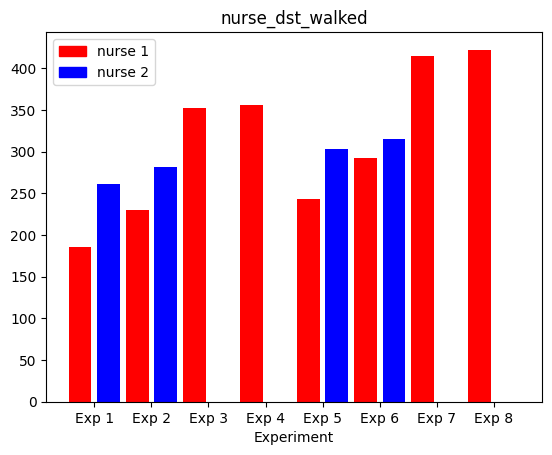

['Exp 1', 'Exp 2', 'Exp 3', 'Exp 4', 'Exp 5', 'Exp 6', 'Exp 7', 'Exp 8']
[np.float64(185.71041622443613), np.float64(260.8419707858697), np.float64(230.01672120519083), np.float64(282.0), np.float64(352.04079708147333), 0.0, np.float64(356.3303808570372), 0.0, np.float64(243.45253819946728), np.float64(302.8419707858697), np.float64(291.75884318022196), np.float64(315.0), np.float64(414.7829190565045), 0.0, np.float64(422.0725028320684), 0.0]


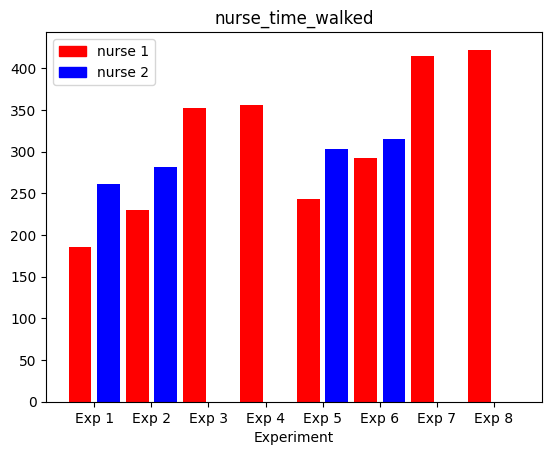

['Exp 1', 'Exp 2', 'Exp 3', 'Exp 4', 'Exp 5', 'Exp 6', 'Exp 7', 'Exp 8']
[np.float64(1166.0814598621905), np.float64(1245.7801659597721), np.float64(973.639163785211), np.float64(950.1829468221015), np.float64(2411.861625821963), 0.0, np.float64(2411.861625821963), 0.0, np.float64(1166.0814598621905), np.float64(1245.7801659597721), np.float64(953.0656316084628), np.float64(980.991081035264), np.float64(2411.861625821963), 0.0, np.float64(2411.8616258219636), 0.0]


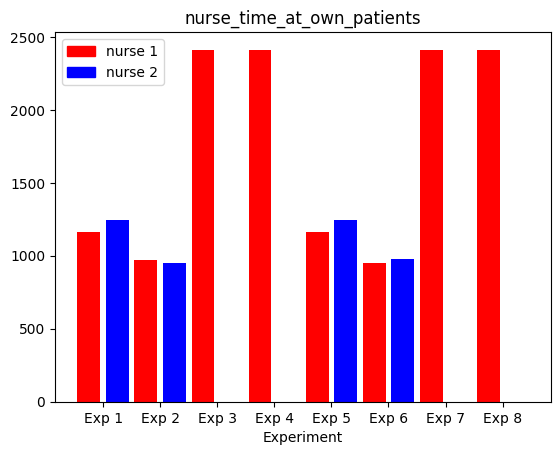

['Exp 1', 'Exp 2', 'Exp 3', 'Exp 4', 'Exp 5', 'Exp 6', 'Exp 7', 'Exp 8']
[0.0, 0.0, np.float64(295.59721913767055), np.float64(192.44229607697937), 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, np.float64(264.78908492450853), np.float64(213.0158282537276), 0.0, 0.0, 0.0, 0.0]


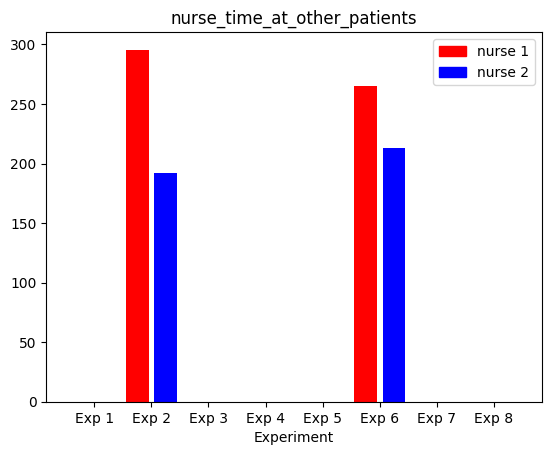

['Exp 1', 'Exp 2', 'Exp 3', 'Exp 4', 'Exp 5', 'Exp 6', 'Exp 7', 'Exp 8']
[np.float64(1966.994275686039), np.float64(1812.1640150270237), np.float64(1819.5330476445931), np.float64(1894.1609088735847), np.float64(622.9748135558734), 0.0, np.float64(602.6852297803096), 0.0, np.float64(1909.2521537110078), np.float64(1770.1640150270237), np.float64(1809.1725920594724), np.float64(1809.7792424836741), np.float64(560.2326915808422), 0.0, np.float64(536.9431078052779), 0.0]


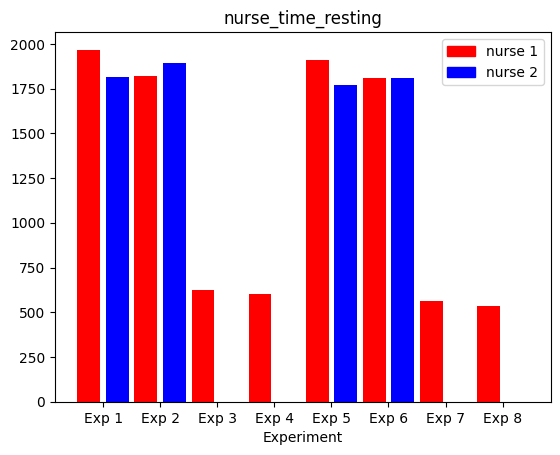

In [52]:
def plot_nurse_stat(stat_name):
    values = [0 for _ in range(len(nurse_results) * 2 )] # amounts to be plotted in bar chart
    runs = len(nurse_results[0])
    for i, exp in enumerate(nurse_results):
        for run in exp:
            values[i * 2] += run[0][stat_name]
            # values.append(run[0][stat_name])
            if len(run) == 2: # there are two nurses, so update the second bar of that experiment
                # values.append(run[1][stat_name])
                values[i * 2 + 1] += run[1][stat_name]
            # else:
                # values.append(0)

    # values has the sum of all results, average them
    values = list(map(lambda x: x / runs, values)) 

    labels = ["Exp " + str(x + 1) for x in range(8)] # experiment scenario names
    colors = ['red' if i % 2 == 0 else 'blue' for i in range(len(values))] #alternating colors for nurses
    print(labels)
    print(values)
    x = np.arange(len(values))

    # plot the actual bars
    plt.bar(x, values, color=colors)

    # write labels under each pair of values
    plt.xticks(ticks=np.arange(0.5, len(values), 2), labels=labels)

    # red_patch = plt.Line2D([0], [0], color='red', lw=4, label='nurse 1')
    # blue_patch = plt.Line2D([0], [0], color='blue', lw=4, label='nurse 2')
    # create legend
    red_patch = mpatches.Circle((0, 0), radius=0.1, color='red', label='nurse 1')
    blue_patch = mpatches.Circle((0, 0), radius=0.1, color='blue', label='nurse 2')
    plt.legend(handles=[red_patch, blue_patch])

    # titles
    plt.xlabel("Experiment")
    plt.ylabel("")
    plt.title(stat_name)

    plt.show()

nurse_stats = nurse_results[0][0][0].keys()
for stat in nurse_stats:
    plot_nurse_stat(stat)

In [ ]:
def plot_nurse_stat_avg(stat_name):
    values = [0 for _ in range(len(nurse_results) * 2 )] # amounts to be plotted in bar chart
    runs = len(nurse_results[0])
    for i, exp in enumerate(nurse_results):
        for run in exp:
            values[i * 2] += run[0][stat_name]
            # values.append(run[0][stat_name])
            if len(run) == 2: # there are two nurses, so update the second bar of that experiment
                # values.append(run[1][stat_name])
                values[i * 2 + 1] += run[1][stat_name]
            # else:
                # values.append(0)

    # values has the sum of all results, average them
    values = list(map(lambda x: x / runs, values)) 

    labels = ["Exp " + str(x + 1) for x in range(8)] # experiment scenario names
    colors = ['red' if i % 2 == 0 else 'blue' for i in range(len(values))] #alternating colors for nurses
    print(labels)
    print(values)
    x = np.arange(len(values))

    # plot the actual bars
    plt.bar(x, values, color=colors)

    # write labels under each pair of values
    plt.xticks(ticks=np.arange(0.5, len(values), 2), labels=labels)

    # red_patch = plt.Line2D([0], [0], color='red', lw=4, label='nurse 1')
    # blue_patch = plt.Line2D([0], [0], color='blue', lw=4, label='nurse 2')
    # create legend
    red_patch = mpatches.Circle((0, 0), radius=0.1, color='red', label='nurse 1')
    blue_patch = mpatches.Circle((0, 0), radius=0.1, color='blue', label='nurse 2')
    plt.legend(handles=[red_patch, blue_patch])

    # titles
    plt.xlabel("Experiment")
    plt.ylabel("")
    plt.title(stat_name)

    plt.show()

nurse_stats = nurse_results[0][0][0].keys()
for stat in nurse_stats:
    plot_nurse_stat(stat)

## Test prints

In [ ]:
df = pd.read_csv(project_root + "/output/testNurseLog.csv")
df

In [ ]:
time_rows = df[(df['nurse'] == 0) & (df['patient'] == 0) & (df['action'] == "time at patient")].event.tolist()
time_rows


In [ ]:
df115 = df[df['event'] == 82].reset_index(drop=True)
df115

In [ ]:
# Find the index of the row where action is 'time at patient'
time_at_patient_idx = df115[df115['action'] == 'time at patient'].index[0]
print(time_at_patient_idx)

total_time = 0
int_end_time = df115.loc[time_at_patient_idx].time #end of current calculated interval
# Iterate backward from this index to find the first occurrence of 'move to'
for idx in range(time_at_patient_idx, -1, -1):
    line = df115.loc[idx]
    action = line["action"]
    if action == 'move to' or idx == 0:
        total_time += int_end_time - line["time"]
        break
    if action == 'assign event':
        total_time += int_end_time - line["time"]
    elif action == 'unassign event':
        int_end_time = line["time"]
    print(idx, action, total_time)

print(total_time)

In [ ]:
df115.iloc[-1]

In [ ]:
req_levels = [2, 3]
level_probabilities = [0.75, 0.25]
level = np.random.choice(req_levels, p=level_probabilities)
req = {}
req["level"] = level

print(req["level"])

In [ ]:
val = np.int64(2)
print(type(int(val)))